In [1]:
import MakeModel
from MakeModel import *
%matplotlib widget

### This notebook is intended to be used to create a 1D planetary model suitable to be ingested in R3D code

In [2]:
basedir = os.path.dirname(os.getcwd())
directory = f'{basedir}/Models/MoonModels/'
model_name = 'Garcia M2' #Possible values: 'Garcia M2','Garcia M3', 'Weber', 

if model_name == 'Garcia M2':
    file = 'ISSI_MOON_M2.nd'
elif model_name == 'Garcia M3':
    file = 'ISSI_MOON_M3MOD.nd'
elif model_name == 'Weber':
    file = 'MoonWeber_Science_2011.nd'

# path to path
filepath  = directory  + file
# GET THE DATA FRAME 
model  = velocity_model.VelocityModel.read_nd_file(filepath)
Model_dF = getDfFromND(model)
# Remove duplicates to avoid redundant entries
Model_dF = Model_dF.drop_duplicates().sort_values(by="Depth").reset_index(drop=True)


#### Here we have two discontinuities, and we approximate the decreasing velocity at the bottom of the mantle with 2 cells. Thus we will use 2 + 2 + 1 = 5 cells in total.

In [3]:
depths = Model_dF['Depth'].values
vp = Model_dF['Vp'].values
print('Printing the discontinuities in depth to help the user pick the layers:\n')
for i in range(1, len(depths)):
    if depths[i] == depths[i-1]:
        print(f"Discontinuity in depth found at index {i-1}: {depths[i]}")

print("\nIn the next cell, we will pick the discontinuities and choose connstant cells for each layer.")
print("To decide the number of Nodes, the general rule should be : N_nodes = 2* N_gradients")
print("\nThe gradient can be positive or negative. The user justs needs to pick the starting and ending points of each layer.")

Printing the discontinuities in depth to help the user pick the layers:

Discontinuity in depth found at index 28: 28.0
Discontinuity in depth found at index 1324: 1323.0

In the next cell, we will pick the discontinuities and choose connstant cells for each layer.
To decide the number of Nodes, the general rule should be : N_nodes = 2* N_gradients

The gradient can be positive or negative. The user justs needs to pick the starting and ending points of each layer.


IntText(value=8, description='Number of points:')

Button(description='Start Selection', style=ButtonStyle())

Textarea(value='', description='Selected:', layout=Layout(height='120px', width='50%'), placeholder='Selected …

Output()

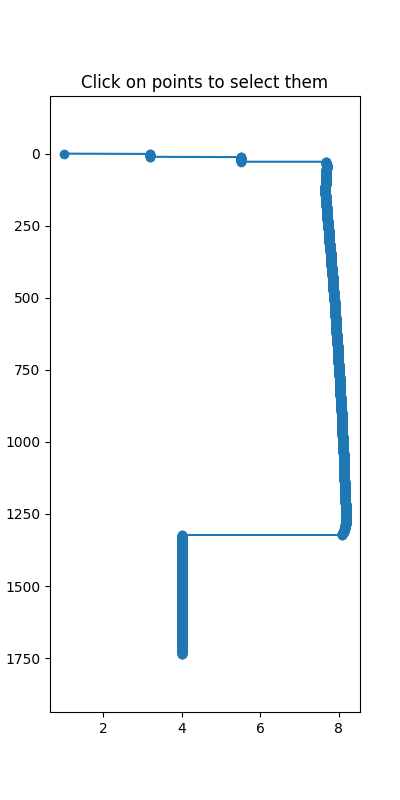

In [22]:
import MakeModel
from importlib import reload
reload(MakeModel)
from MakeModel import *

results = []
# Run the interactive picker. Chose npts =8 because we want 4 gradients : Crust, Mantle, Slow layer, Core

results = interactive_point_selector(vp, depths,npts = 8)
plt.ylim(np.max(depths) + 200, -200)
plt.show()

### Here we create the constant cell to model the negative velocity gradients

In [43]:
# Negative volocity gradients are not allowed, so we need to split the negative gradient in constant cells.
depth1,depth2 = 1288,1324
veclocity_gradients = [(depth1,depth2)]

# Chose a number of constant cells to approximate the velocity profile for negative gradients.
nCells = 5
# Loop over all the negative gradients.

selected_indices = []
for depth1, depth2 in veclocity_gradients:
    depths_select = depths[(depths >= depth1) & (depths <= depth2)]

    # Select 5 constant cells trough the selected depths to approximate the velocity profile.
    # Iteratively pick a Vp and only chose decreasing values.
    first_vp = vp[np.where(depths == depths_select[0])[0][0]]
    iterator =0
    for i in range(nCells):
        vp_select = vp[np.where(depths == depths_select[iterator])[0][0]]
        #print(f"Selected Vp: {vp_select} at depth {depths_select[iterator]}")
        while vp_select >= first_vp:
            #print(f"Selected Vp: {vp_select}, first Vp: {first_vp}, at depth {depths_select[iterator]}")
            iterator += 1
            if iterator >= len(depths_select) -1: # remove the last point because it might be the value after the last discontinuity
                break
            vp_select = vp[np.where(depths == depths_select[iterator])[0][0]]
            
        # If after iterating through all the depths, the selected Vp is still the same as the first Vp, we stop the iteration.    
        if vp_select == first_vp:
            print('Too many cells, stopping iteration.')
            break
        first_vp = vp_select
        # Add the current index
        
        depth_index = np.where(depths == depths_select[iterator])[0][0]
        selected_indices.append(depth_index)
        
print(f"Selected indices: {selected_indices}")

Too many cells, stopping iteration.
Selected indices: [np.int64(1299), np.int64(1304), np.int64(1314), np.int64(1319)]


### Next, we create a new data frame containing the simplified model

In [44]:
ParamNames = ["Depth","Vp","Vs","Density","Qkappa","Qmu","epsilon","a","kappa","nu"]
Simplified_dF=pd.DataFrame(columns=ParamNames)

for name in ParamNames:    
    if name not in Model_dF.columns:
        Model_dF[name] = np.nan

In [63]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
indexes,values,decision =zip(*results)
indices = list(indexes)

for idx in selected_indices:
    indices.append(idx)
indices = sorted(indices)  # Remove duplicates and sort the indices
 
# Make the order of decision the same as the indices
for name in ParamNames:
    Simplified_dF[name] = np.nan  # Initialize with NaN

    for i, idx in enumerate(indices):
        Simplified_dF.loc[i, name] = Model_dF.loc[idx, name]

    for i in range(1, len(indices) - 1, 2):
        if indices[i] + 1 != indices[i + 1]:
            Simplified_dF.loc[i + 1, name] = Simplified_dF.loc[i, name]


Simplified_dF

,Depth,Vp,Vs,Density,Qkappa,Qmu,epsilon,a,kappa,nu
0,0.0,1.00,0.50,2.60,1000.0,2000.0,NaN,NaN,NaN,NaN
1,28.0,5.50,3.30,2.60,1000.0,2000.0,NaN,NaN,NaN,NaN
2,28.0,7.68,4.41,3.34,1000.0,2000.0,NaN,NaN,NaN,NaN
3,1258.0,8.18,4.69,3.44,1000.0,2000.0,NaN,NaN,NaN,NaN
4,1258.0,8.18,4.69,3.44,1000.0,2000.0,NaN,NaN,NaN,NaN
5,1298.0,8.15,4.57,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN
6,1298.0,8.15,4.57,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN
7,1313.0,8.11,4.51,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN
8,1313.0,8.11,4.51,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN
9,1323.0,8.07,4.48,3.46,1000.0,2000.0,NaN,NaN,NaN,NaN


### Make sure there is no negative velocity gradient

In [64]:
# Make sure there is no negative velocity gradient.
for i in range(1, len(Simplified_dF['Vp']) - 1,2):
    if Simplified_dF['Vp'].iloc[i] < Simplified_dF['Vp'].iloc[i - 1]:
        
        # Change all the values in the current layer to the previous value.
        
        print(f"Detected negative gradient at index {i} : {Simplified_dF['Vp'].iloc[i]} < {Simplified_dF['Vp'].iloc[i - 1]}")
        
        for name in ParamNames:
            Simplified_dF[name].iloc[i] = Simplified_dF[name].iloc[i - 1]
            
        print(f"Changed the value at index {i} to {Simplified_dF['Vp'].iloc[i]}")
        
Simplified_dF

Detected negative gradient at index 5 : 8.15 < 8.18
Changed the value at index 5 to 8.18
Detected negative gradient at index 7 : 8.11 < 8.15
Changed the value at index 7 to 8.15
Detected negative gradient at index 9 : 8.07 < 8.11
Changed the value at index 9 to 8.11


,Depth,Vp,Vs,Density,Qkappa,Qmu,epsilon,a,kappa,nu
0,0.0,1.00,0.50,2.60,1000.0,2000.0,NaN,NaN,NaN,NaN
1,28.0,5.50,3.30,2.60,1000.0,2000.0,NaN,NaN,NaN,NaN
2,28.0,7.68,4.41,3.34,1000.0,2000.0,NaN,NaN,NaN,NaN
3,1258.0,8.18,4.69,3.44,1000.0,2000.0,NaN,NaN,NaN,NaN
4,1258.0,8.18,4.69,3.44,1000.0,2000.0,NaN,NaN,NaN,NaN
5,1258.0,8.18,4.69,3.44,1000.0,2000.0,NaN,NaN,NaN,NaN
6,1298.0,8.15,4.57,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN
7,1298.0,8.15,4.57,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN
8,1313.0,8.11,4.51,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN
9,1313.0,8.11,4.51,3.45,1000.0,2000.0,NaN,NaN,NaN,NaN


## Visualise the model

(1937.1, -200.0)

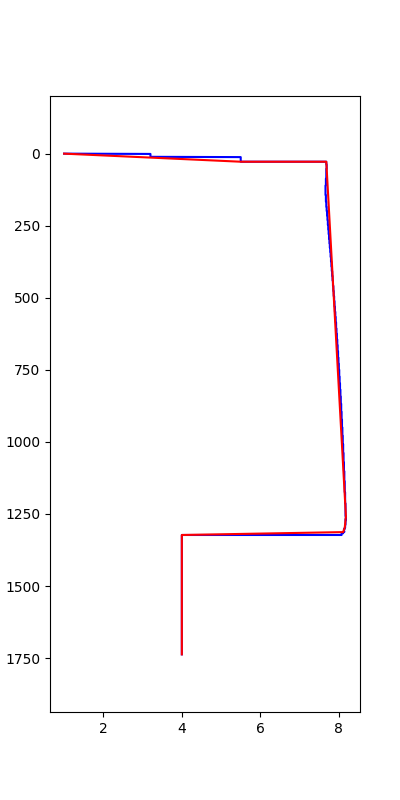

In [66]:
fig,ax= plt.subplots(figsize=(4, 8))
ax.plot(vp, depths, label='Vp', color='blue')
ax.plot(Simplified_dF['Vp'], Simplified_dF['Depth'], color='red', label='Selected Points', zorder=5)
ax.set_ylim(np.max(depths) + 200, -200)

### ADD ATTENUATION

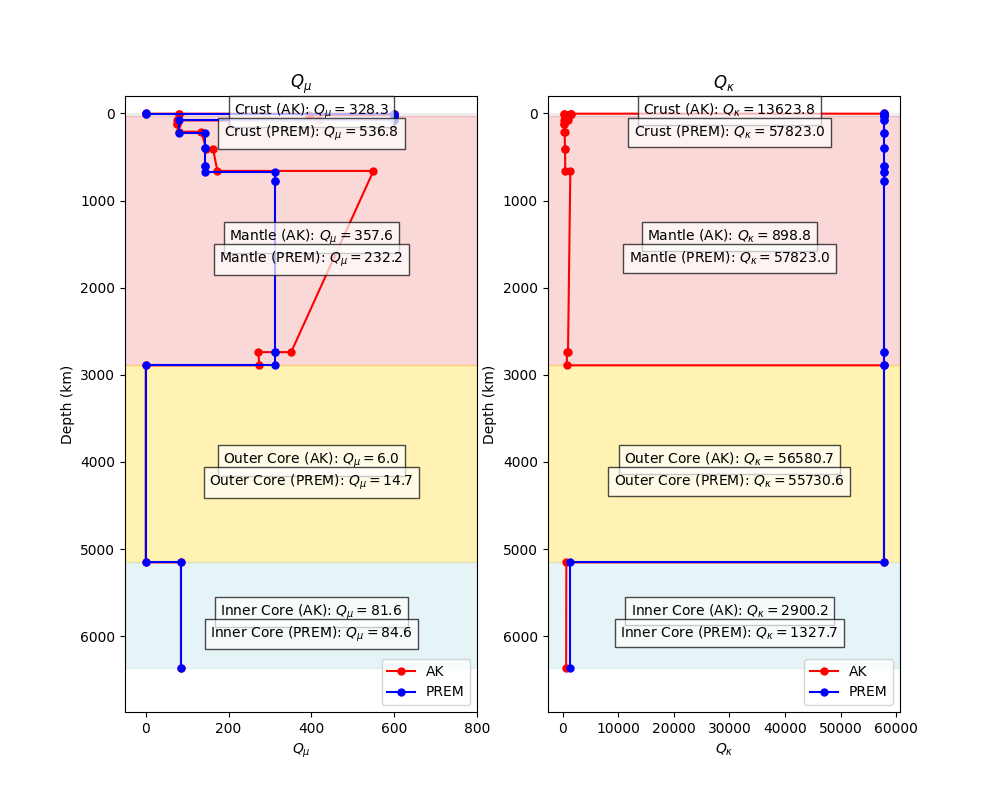

In [68]:
## Chose Attenuation values from PREM or AK35f

PREM_FilePath = f'{basedir}/Models/EarthModels/PREM/PREM_1s.csv'
AK_FilePath = f'{basedir}/Models/EarthModels/AK135F/AK135F_AVG.csv'

mean_Qmu_values, mean_Qkappa_values = getQmuQkappa_PREM_AK(PREM_FilePath, AK_FilePath)

In [69]:
## Start loop. For each identified discontinuity, update Q value with a chosen model value (PREM OR AK).
layerDepths = Simplified_dF['Depth'].values
layerLabels = ['Crust', 
               'Crust', 
               'Mantle', 
               'Mantle',
               'Mantle',
               'Mantle',
               'Mantle',
               'Mantle', 
               'Outer Core',
               'Outer Core',
               'Outer Core',
               'Outer Core',
               ]

which_model  = 'AK' # choosing the Q values of AK

Simplified_dF['Qmu'] = [mean_Qmu_values[which_model][layer] for layer in layerLabels]
Simplified_dF['Qkappa'] = [mean_Qkappa_values[which_model][layer] for layer in layerLabels]

Simplified_dF

,Depth,Vp,Vs,Density,Qkappa,Qmu,epsilon,a,kappa,nu
0,0.0,1.00,0.50,2.60,13623.760000,328.286667,NaN,NaN,NaN,NaN
1,28.0,5.50,3.30,2.60,13623.760000,328.286667,NaN,NaN,NaN,NaN
2,28.0,7.68,4.41,3.34,898.777031,357.579063,NaN,NaN,NaN,NaN
3,1258.0,8.18,4.69,3.44,898.777031,357.579063,NaN,NaN,NaN,NaN
4,1258.0,8.18,4.69,3.44,898.777031,357.579063,NaN,NaN,NaN,NaN
5,1258.0,8.18,4.69,3.44,898.777031,357.579063,NaN,NaN,NaN,NaN
6,1298.0,8.15,4.57,3.45,898.777031,357.579063,NaN,NaN,NaN,NaN
7,1298.0,8.15,4.57,3.45,898.777031,357.579063,NaN,NaN,NaN,NaN
8,1313.0,8.11,4.51,3.45,56580.720000,5.955870,NaN,NaN,NaN,NaN
9,1313.0,8.11,4.51,3.45,56580.720000,5.955870,NaN,NaN,NaN,NaN


### Save the model to a file

In [70]:
import os 
SimplfiedDirectory = directory + 'SimplfiedModels'
os.makedirs(SimplfiedDirectory,exist_ok=True)

nlayers = len(Simplified_dF['Depth'].to_numpy())
Simplified_dF['nNodes'] = np.ones((nlayers))*( nlayers/2 +1) # Need to add this because we will use it in the C++ Code.
newFileName = 'Simplfied' + file.strip()[:-2] + 'csv'
path=SimplfiedDirectory +'/' + newFileName
Simplified_dF.to_csv(path,index=False)
print(f"Saved the simplified model to {path}")

Saved the simplified model to /Users/balthazar/Downloads/Radiative3d-spherical-shells/Models/MoonModels/SimplfiedModels/SimplfiedISSI_MOON_M2.csv


### Add a scattering layer in the crust

In [71]:
Hscatt = 10  # km
epsilon = 0.042
kappa = 0.5
a = 650 * 1E-3  # km
nu = 0.2

Simplfied_dF_scatt = AddScatteringLayerTopCrust(Hscatt, Simplified_dF, epsilon, kappa, a, nu)


### Save the crustal Scattering model

In [72]:
# Save the new model to a CSV file
import os 
SimplfiedDirectory = directory + 'SimplfiedModels'
os.makedirs(SimplfiedDirectory,exist_ok=True)

nlayers = len(Simplfied_dF_scatt['Depth'].to_numpy())
Simplfied_dF_scatt['nNodes'] = np.ones((nlayers))*( nlayers/2 +1)
newFileName = 'Simplfied' + file.strip()[:-2] + 'CrustalScat.csv'
path=SimplfiedDirectory +'/' + newFileName
Simplfied_dF_scatt.to_csv(path,index=False)
print(f"Saved the simplified model with scattering layer to {path}")

Saved the simplified model with scattering layer to /Users/balthazar/Downloads/Radiative3d-spherical-shells/Models/MoonModels/SimplfiedModels/SimplfiedISSI_MOON_M2.CrustalScat.csv


### Same with the mantle

In [73]:
epsilon = 0.042
kappa = 0.5
a = 650 * 1E-3  # km
nu = 0.2
Hscatt = 10  # km
layer = 'Mantle'  # Layer number (0 for crustal layer)

# Add the scattering layer
model  = velocity_model.VelocityModel.read_nd_file(filepath)
layerDepth = GetLayerDepth(model,layer)
Simplfied_dF_scatt_Mantle = AddScatteringLayerTop(model,layerDepth, Hscatt, Simplified_dF, epsilon, kappa, a, nu)

Layer already exists at the specified depth. Adding scattering properties


In [74]:
# Save the new model to a CSV file
import os 
SimplfiedDirectory = directory + 'SimplfiedModels'
os.makedirs(SimplfiedDirectory,exist_ok=True)

nlayers = len(Simplfied_dF_scatt_Mantle['Depth'].to_numpy())
Simplfied_dF_scatt_Mantle['nNodes'] = np.ones((nlayers))*( nlayers/2 +1)
newFileName = 'Simplfied' + file.strip()[:-2] + f'{layer}Scat.csv'
path=SimplfiedDirectory +'/' + newFileName
Simplfied_dF_scatt_Mantle.to_csv(path,index=False)
print(f"Saved the simplified model with scattering layer to {path}")

Saved the simplified model with scattering layer to /Users/balthazar/Downloads/Radiative3d-spherical-shells/Models/MoonModels/SimplfiedModels/SimplfiedISSI_MOON_M2.MantleScat.csv
